In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import glob
import pickle as pkl
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
import os

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


In [5]:
epl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels'
spl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/surface'

regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5),([-7.5,-81],[-3.7,-74])],
'central' : [(-12,-8), ([-10.5,-81],[-6.5,-72])],   # mid:
'southern' : [(-18,-15), ([-17.9,-74.5],[-9.5,-68.5])]}
h = 2000

In [7]:
region = 'central'
alls = regions[region]
ccords = alls[1]

In [8]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [9]:
corr_start = dic['start_3d']
corr_end = dic['end_5d']
corr_start.name = 'r'
corr_end.name = 'r'

In [10]:
dummy = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc')[0]).isel(time=0)
dummy = uda.flip_lat(dummy)

In [11]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-85,-55), lat=slice(-25,3))
topo_on_g = dummy.salem.lookup_transform(topo)

In [12]:
corrs_on_g = dummy.salem.transform(corr_start, interp='nearest').where(topo_on_g>=2000)
corre_on_g = dummy.salem.transform(corr_end, interp='nearest').where(topo_on_g>=2000)

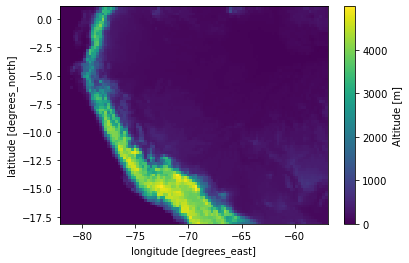

In [13]:
topo_on_g.plot()

In [11]:
start = ccords[0]
end = ccords[1]

In [12]:
#topo_on_g.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc', mode='w', format='NETCDF4')

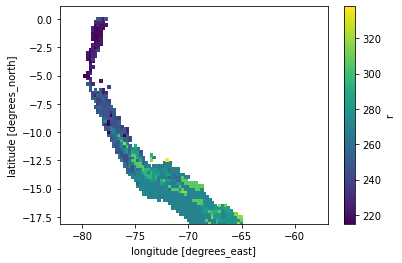

In [13]:
corrs_on_g.plot()

In [14]:
def readERA(r):
    epl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc'
    inputs = glob.glob(epl)
    alls = regions[r]
    
    doys = corrs_on_g.sel(latitude=slice(alls[0][0], alls[0][1])).mean()
    doye = corre_on_g.sel(latitude=slice(alls[0][0], alls[0][1])).mean()
    dsdate = pd.Timestamp('2008-01-01')+pd.Timedelta(str(doys.values)+'days')
    dedate = pd.Timestamp('2008-01-01')+pd.Timedelta(str(doye.values)+'days')
    
    alist = []
    for file in inputs:
        fbasename = os.path.basename(file)
        y = fbasename[5:9]
        m = fbasename[10:12]
        d = fbasename[13:15]
        if (int(y)<1985) | (int(y)>2018):
            continue
        date = pd.Timestamp(y+'-'+m+'-'+d)
        ddoy = date.dayofyear
        print('Doing ', file)
        if (ddoy<doys) & (ddoy>doye):  # check rainy season start end
            print(r, 'start season:', dsdate, 'end season:', dedate)
            print('Outside of rainy season, continue')
            continue

        
        u200orig = xr.open_dataset(file)
        u200orig = uda.flip_lat(u200orig)
        u200orig = u200orig.sel(latitude=slice(alls[0][0], alls[0][1]), time=(u200orig['time.hour']==15)).mean('latitude')
        u200orig = u200orig.drop(['pv'])
        datetimes = pd.to_datetime(u200orig.time.values)
        newtimes = []
        for t in datetimes:
            newtimes.append(t.replace(hour=0))
        u200orig['time'] = ('time', newtimes)
        alist.append(u200orig)
    ds = xr.concat(alist, dim='time')
    
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in ds.data_vars} #{var: comp}
    ds.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+r+'_cross_15UTC_1985-2018_peru_v2.nc', mode='w',
                       encoding=encoding, format='NETCDF4')

In [15]:
readERA('transition')

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_26_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_07_16_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_198

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_06_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_06_24_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end s

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_11_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_27_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_09_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_198

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_06_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_06_27_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_07_13_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_198

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_04_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_04_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_06_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_06_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_06_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_06_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_06_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_04_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_07_21_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end s

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_19_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_20_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_21_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_22_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_l

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_07_09_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_07_10_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_07_11_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_07_12_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Out

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_17_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_18_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_19_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_20_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_21_pl.nc
transi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_04_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_04_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_04_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_06_12_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end s

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_04_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_04_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_09_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_09_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_08_10_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_08_26_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_09_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_200

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_26_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_12_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_28_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_04_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_04_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_06_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_06_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_06_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_06_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_06_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_04_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_06_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_04_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_04_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_07_12_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_07_28_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_13_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_29_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing 

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

In [16]:
readERA('equatorial')

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_26_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_07_16_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_198

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_06_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_06_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_04_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_04_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_06_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_07_18_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_03_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_198

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_07_29_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_07_30_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_07_31_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_08_01_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Out

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_09_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_06_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_06_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_07_22_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_07_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_09_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_199

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_07_26_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_07_27_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_07_28_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_07_29_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Out

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_16_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elemen

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_09_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_06_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_09_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_04_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_07_25_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_12_pl.nc
Doing  /media/ck/Elemen

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_08_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_09_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_07_28_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elemen

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_06_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_04_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_04_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_08_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_08_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_08_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_08_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_08_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_09_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_07_20_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_08_05_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_201

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_07_27_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_07_28_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_07_29_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_07_30_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Out

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_04_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_06_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_06_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_07_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_08_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_08_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_08_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_08_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_08_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_08_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_09_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_08_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_09_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_07_26_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_07_27_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_07_28_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_07_29_pl.nc
equatorial start season: 2008-08-10 22:15:39.130444800 end season: 2008-07-15 00:20:52.173945600
Out

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_06_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_06_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_06_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_06_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_06_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_07_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_07_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_07_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_07_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_07_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_08_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_09_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_24_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_14_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_15_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_22_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres